# Data Analysis

## Temporal Data Analysis: A gentle intro to timeseries

Timeseries analysis can be a course (or multiple courses) on its own but in this lecture we will try to cover some basics, namely:

* a general intro to temporal data analysis 
* visualizing time series 
* exploring stationarity of time series
* autoregressive models (and ARIMA) as a baseline
* importing stock data using the pandas_datareader python package 
* simple ways to break Wall Street

Further reading: 
+ Yves Hilpisch, Python for Finance, O'Reilly, (2014)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

## 0. Temporal data analysis

A *time series* is a series of data points indexed by time, $x_i = x(t_i)$, for $i=1,\ldots,n$. Examples frequently occur in 
* weather forecasting, 
* mathematical finance (stocks),
* electricity demand in a power grid, 
* COVID-19 cases per day, and in general...
* any applied science and engineering which involves temporal measurements

*Temporal data analysis* or *time series analysis* is just the study of such data. 

We want to observe the timeseries and draw conclusions: 
+ Descriptive/Exploratory, e.g. estimating summary measures (e.g. mean, variance)
+ Inferential: Understanding / Modeling
+ Prediction/Forecasting



### 0.1 Problems with timeseries

The main problem we have can be summarized as follows:

If correlation is present between the observations (data points), then our typical approaches are not “really correct” (as they assume independency). Most likely we need to check our timeseries for such patterns and remove any structure before proceeding with any model. We refer to this problem as (weak) stationarity of the series.

For being able to do statistics with time series, we require that the series “doesn’t change its probabilistic character” over time. This is mathematically formulated by weak stationarity.

The simplest model to describe some time series would be to have a random variable $X_t$ ($t=1,2,3...$) derived from a gaussian distribution $\mathcal{N}(0,\sigma^2)$. That defines a purely random process.

**Definition:** A time series Xt is said to be weakly stationary, if :
+ $E[X_t]=\mu$: all $X$ have identical expected mean
+ $Var(X_t)=\sigma^2$: all $X_t$ have identical variance
+ $Cov(X_t,X_{t+h}) = \gamma_h$: autocovariance depends only on lag $h$

Stationarity is a key assumption, but real data will demonstrate trends, seasonalities and as such they are non-stationary. We can (often) deal with that using the additive (or multiplicative) decomposition model:

$$
x_t = m_t + s_t + r_t\\
= \text{trend + seasonal effect + stationary remainder}
$$

## 1. Looking into the data

As with every new dataset, the first step is to load data and inspect it. We are going to be using an example from the Retail Sales Index on Alcoholic Drinks which gives us the monthly estimate of retail sales in value and volume terms for Great Britain (years 1988 till 2023). You can find the original data [here](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/timeseries/cy45)

Let's load this dataset into pandas!

In [2]:
df = pd.read_csv("data/alcohol.csv", header=None, skiprows=8, parse_dates=[0], names=['period', 'value'])
#take the first col 0, into dates format 
df.value.astype(int, copy=False);
df.head(10)

,period,value
0,1988-01-01,119.8
1,1988-02-01,125.3
2,1988-03-01,131.4
3,1988-04-01,134.9
4,1988-05-01,136.8
5,1988-06-01,136.9
6,1988-07-01,139.6
7,1988-08-01,144.3
8,1988-09-01,134.6
9,1988-10-01,137.8


In [3]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1988 - 01.01.2023
Number of data points: 421 of expected 421


### Visualize the data

We already hinted that the observations might not be independent, another issue we see from plotting the series is that there is more structure in the data (in the form of a trend and a seasonality). Moreover, there can be external events that might affect the value of the timeseries.

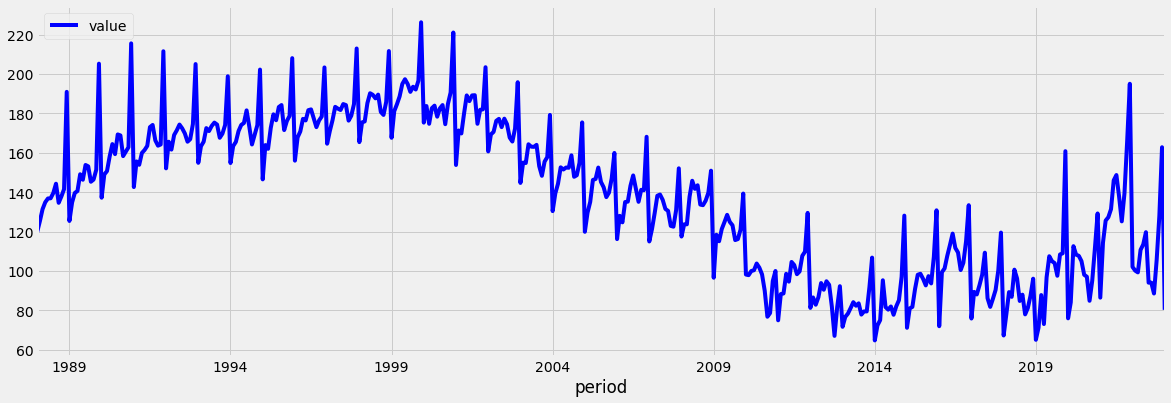

In [4]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", color="blue", ax=ax)
plt.legend(loc='upper left')
#plt.savefig('images/intro-visualization.png');

We can also zoom-in to check specific periods of time

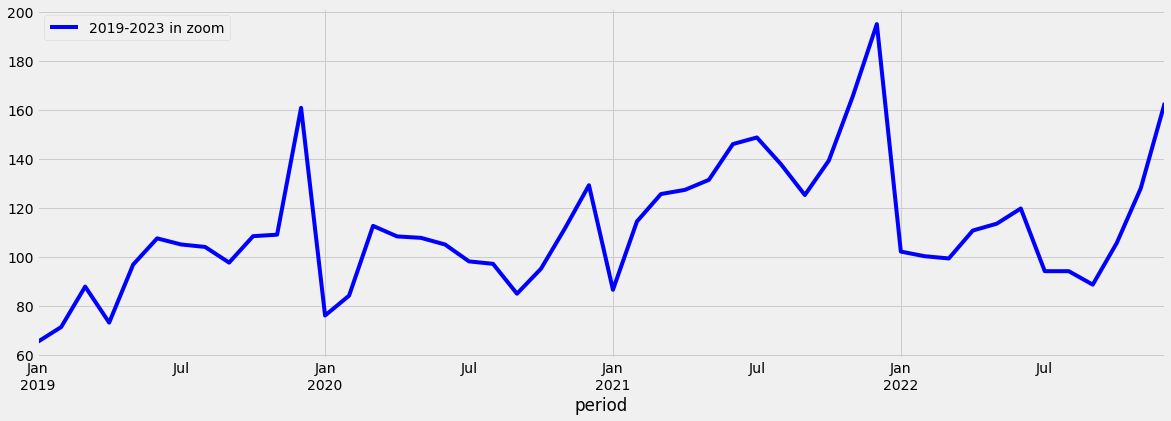

In [5]:
zoom_range = df[(df.period >= '2019-01-01') & (df.period < '2023-01-01')].index

fig, ax = plt.subplots(figsize=(18,6))
df.loc[zoom_range].plot(x="period", y="value", ax=ax, color="blue", label="2019-2023 in zoom")
plt.legend(loc='upper left')

#plt.savefig('images/intro-zoom.png');

### 1.1 Initial exploration: Trend and seasonality

From the visualization it's already quite obvious that the timeseries has periodic fluctuations each year and overall tendency to grow up (initially) and then go down.

Thus, we can conclude that the time series has a **trend** and yearly **seasonality** components, and we can try to identify them either using our own models, or tools available via **statsmodels** package (see [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) and [code](https://www.statsmodels.org/stable/_modules/statsmodels/tsa/seasonal.html#seasonal_decompose) here).

### The Trend

What would be a reasonable approach to compute the trend?

Fit a linear (or polynomial) model to the data! We know how to do that!

**POLL** Is it a good idea to run regression on time? True of False?

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # yearly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    period = decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

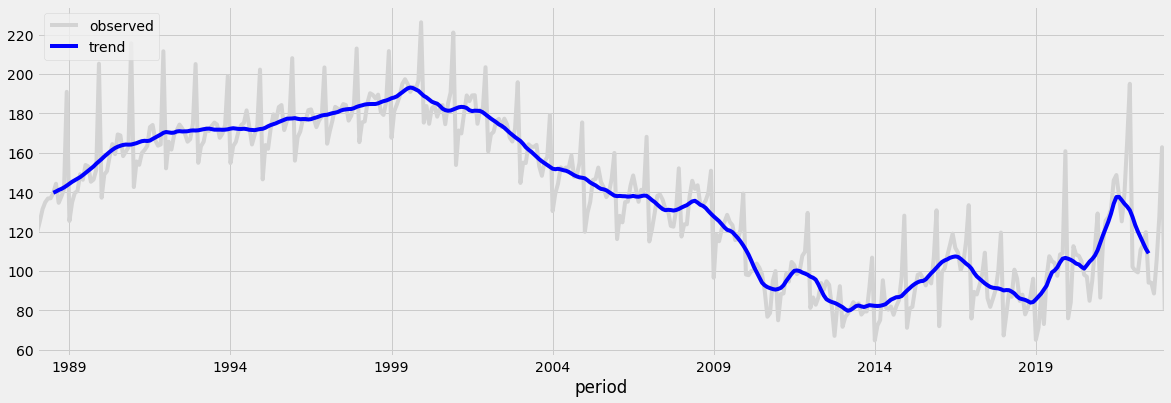

In [7]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="blue")
plt.legend(loc='upper left')

#plt.savefig('images/intro-trend.png');

### The Seasonality

There are many types of seasonality, e.g. time of day, daily, weekly, monthy, yearly, etc. As such, identifying whether there is a seasonality component in a time series depends on the specific context.

Once we identify the seasonality pattern, we can remove it from the data by differencing accordingly (e.g. in this example we identified a yearly seasonality (every 12 months).


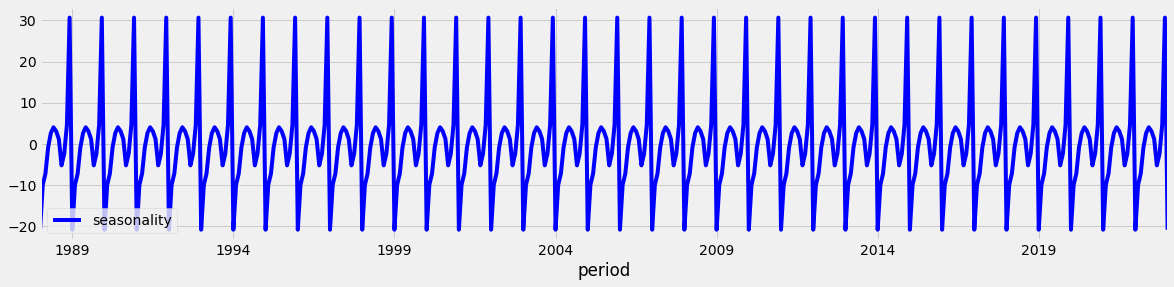

In [8]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality", color="blue")
plt.legend(loc='lower left')

#plt.savefig('images/intro-seasonality.png');

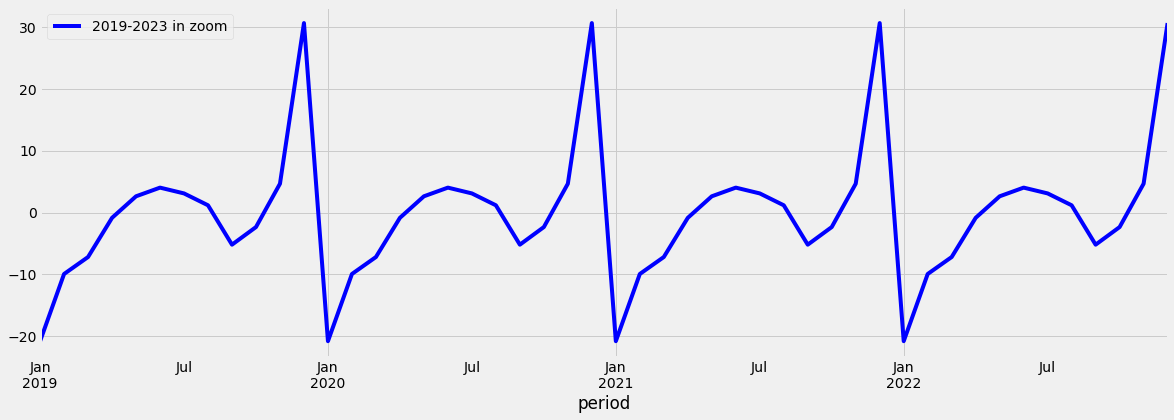

In [9]:
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", color="blue", ax=ax, label="2019-2023 in zoom")
plt.legend(loc='upper left')

#plt.savefig('images/intro-seasonality-zoom.png');

### The Residual

Once we remove the trend and the seasonality, we are left with the remainder (or residual) part of the timeseries, that we expect it satisfies the properties of stationarity (see below) and we can do further modeling on it.

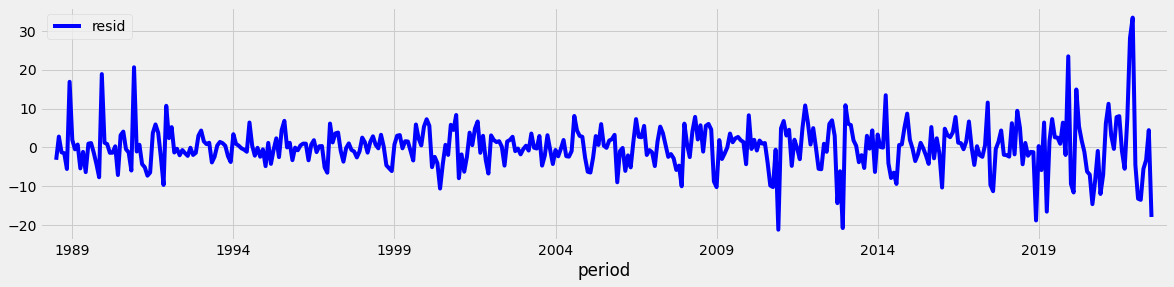

In [10]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="blue")
plt.legend(loc='upper left')

#plt.savefig('images/intro-residual.png');

## 1.2. The big question of stationarity

A **non-stationary** time series shows seasonal effects, trends, and other structures that depend on the time index.

A time series is **stationary** if its statistical properties are all constant over time. More specifically a stationary timeseries has the following properties:

* no trend
* variations around its mean have a constant amplitude
* it wiggles in a consistent fashion (i.e., its short-term random time patterns always look the same)

But how do we check for it?


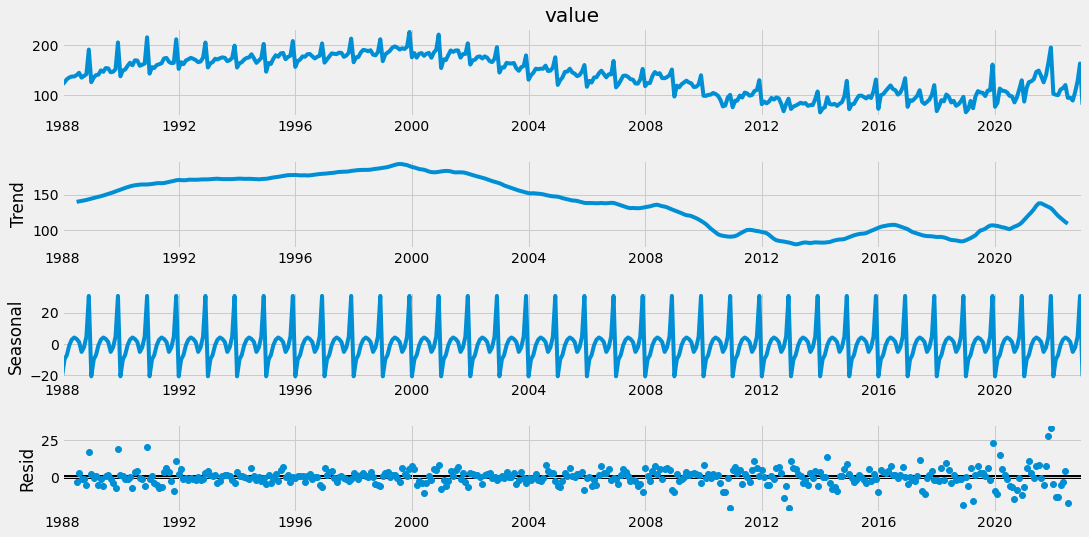

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasons = 12
decompfreq = seasons
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    period=decompfreq,
    model=model)

fig = decomposition.plot()
fig.set_size_inches(16, 8)

#plt.savefig('images/stochastic-decomposition.png');

## 2. Stationarity consistency checks

There are different ways to check for stationarity:

1. Visual check on the timeseries plot (not very scientific, but still can give us insights)
+ Statistical tests that check the properties of the timeseries. 
+ The Correlogram

If my timeseries violates the stationarity assumption, there might be a way to correct it.

### 2.1 Visual check using seasonal (rolling) statistics

In [12]:
#function for the visual check of rolling statistics
def visual_check(df, value, seasons, save_to=None):
    #double check this is correct!
    seasonal_mean = df.set_index("period").rolling(seasons).mean().reset_index()
    seasonal_std = df.set_index("period").rolling(seasons).std().reset_index()

    fig, ax = plt.subplots(figsize=(18,6))
    df.plot(x="period", y=value, ax=ax, label="observed", c='lightgrey')
    seasonal_mean.plot(x="period", y=value, ax=ax, label="seasonal (rolling) mean", c='blue')
    seasonal_std.plot(x="period", y=value, ax=ax, label="seasonal (rolling) std", c='green')

    plt.legend(loc='best')
    plt.title('Seasonal Mean & Standard Deviation')
    
    if save_to is not None:
        plt.savefig(save_to)
    plt.show();

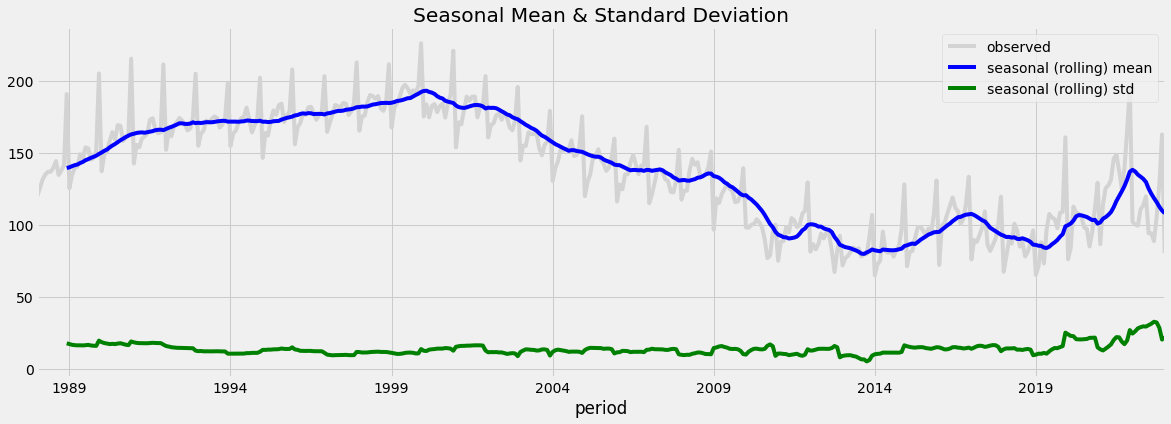

In [13]:
visual_check(df, "value", seasons)
#the std doesnt really change 

### 2.2 Statistical Tests

### a) Augmented Dickey-Fuller ([ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) unit root test

#### What is a unit root?
Very roughly, if $y$ is the timeseries and $\epsilon$ is the noise term, then in the equation (which is a very very simlified representation of the series)

$$
y_t = \alpha \cdot y_{t-1} + \epsilon
$$

when $\alpha=1$, then we say that the timeseries has a unit root and that makes it non-stationary. An intuititve explanation (from [here](https://www.statisticshowto.com/unit-root/#:~:text=A%20unit%20root%20(also%20called,A%20possible%20unit%20root.))) is given below: *The red line shows the drop in output and path of recovery if the time series has a unit root. Blue shows the recovery if there is no unit root and the series is trend-stationary.*

the red line shows the sudden change that will make the data no longer staitoinary.

![](unit-root.png)

The Augmented Dickey-Fuller test is used to test for a **unit root** in a time series sample. The presence of the unit root in time series make it non-stationary (has some time-dependent structure). The **null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root, with **the alternative** that there is no unit root. 

#### Interpreting the Results

If the ADF statistic is greater than the critical value (available in the tables and returned by the function for significancy levels of 10%, 5% and 1%), then the null hypothesis is rejected, so the unit root is not present and the time series is stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance. 

In [14]:
from statsmodels.tsa.stattools import adfuller

def is_stationary_with_adf(data, significance_level=0.05):
    """Decide if the given time series is stationary using ADF test."""
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    print("ADF p-value: {:0.5f}".format(p_value))
    return p_value < significance_level

### b) Kwiatkowski-Phillips-Schmidt-Shin ([KPSS](http://www.statisticshowto.com/kpss-test/)) test for stationarity

The KPSS statistic checks if the timeseries is stationary around the mean (or the trend). The series is broken down to 3 parts (the trend, the stationary error and a random *iid* process with mean 0 and variance $\sigma^2$). If variance is confirmed to be 0, then the random process is a constant, meaning that it is stationary.

The **null hypothesis** of the KPSS test is that the time series is level stationary or trend stationary (stationary around the deterministic trend), the alternative that there is a unit root.

* Contrary to most unit root tests, the presence of a unit root is not the null hypothesis but the alternative.
* A major disadvantage for the KPSS test is that it has a high rate of Type I errors (it tends to reject the null hypothesis too often).
* One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is.

#### Interpreting the Results

If the KPSS statistic is greater than the critical value (given in the table and returned by the function for significancy levels of 10%, 5%, 2.5% and 1%), then the null hypothesis is rejected, so the time series is non-stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance.

In [15]:
from statsmodels.tsa.stattools import kpss

def is_stationary_with_kpss(data, significance_level=0.05):
    """Decide if the given time series is stationary using KPSS test."""
    test = kpss(data, regression='c')
    p_value = test[1]
    print("KPSS p-value: {:0.5f}".format(p_value))
    return p_value > significance_level

In [16]:
significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.value.values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.value.values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.80228
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### 2.3 The correlogram intuition 

The intuition behind correlogram is easy to understand if we are thinking like we want to predict. That is, for a purely random series, the given data can **NOT** help in predicting $x_{n+1}$. In particular, $x_1$ can not predict $x_2$ and $x_2$ can not predict $x_3$ and so on.

Therefore, the correlation coefficient between $x = (x_1, ..., x_{n-1})$ and $x' = (x_2, ..., x_n)$ must be close to zero.

$$
r_1 = \frac{\sum_{t=1}^{n-1}(x_t-\bar x)(x_{t+1}-\bar x)}{\sum_{t=1}^n(x_t-\bar x)^2}
$$

where $\bar x$ is the mean of $x$.

The quantity $r_1$ is called the **Sample Autocorrelation Coefficient** of $x$ series at lag one. We take lag one because this correlation is between $x_t$ and $x_{t+1}$.

When the series stems from a purely random process, $r_1$ is close to zero, particularly when $n$ is large. One can similarly consider Sample Autocorrelations at other lags:

$$
r_k = \frac{\sum_{t=1}^{n-k}(x_t-\bar x)(x_{t+k}-\bar x)}{\sum_{t=1}^n(x_t-\bar x)^2}
$$

where $k=1,2,...$


### The correlogram math 

When values $x_1, ..., x_n$ are obtained from a purely random process, then $r_1$, $r_2$, ... are expected to be independently distributed according to $\mathcal{N}(0, 1/n)$.

So, one way of testing if the series is purely random is to plot the sample autocorrelations. This plot is known as the Correlogram.

The correlogram plots $r_k$ against $k$. Obviously, $r_0$ is always 1(corr with it self). The bands correspond to 95% significance levels.

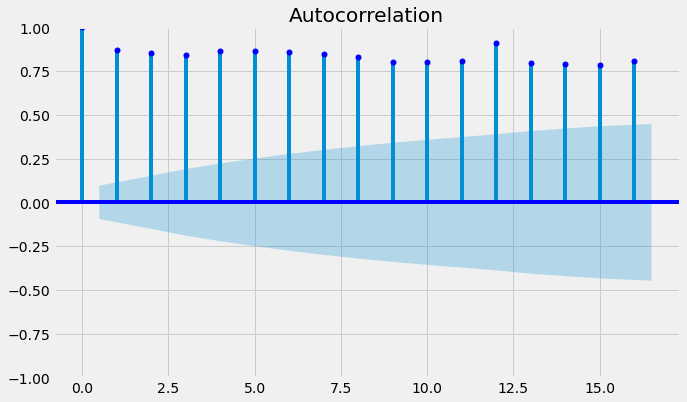

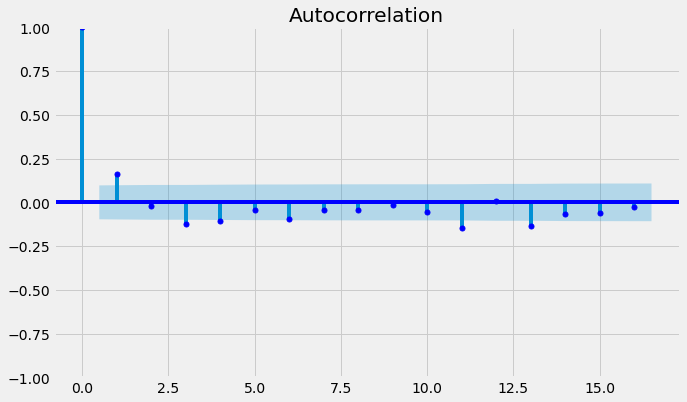

In [17]:
from statsmodels.graphics.tsaplots import plot_acf#, plot_pacf

fig = plot_acf(df.value, color = "blue", lags=16)
fig = plot_acf(residual.dropna(), color = "blue", lags=16)

Let's see two more examples of more extreme cases.

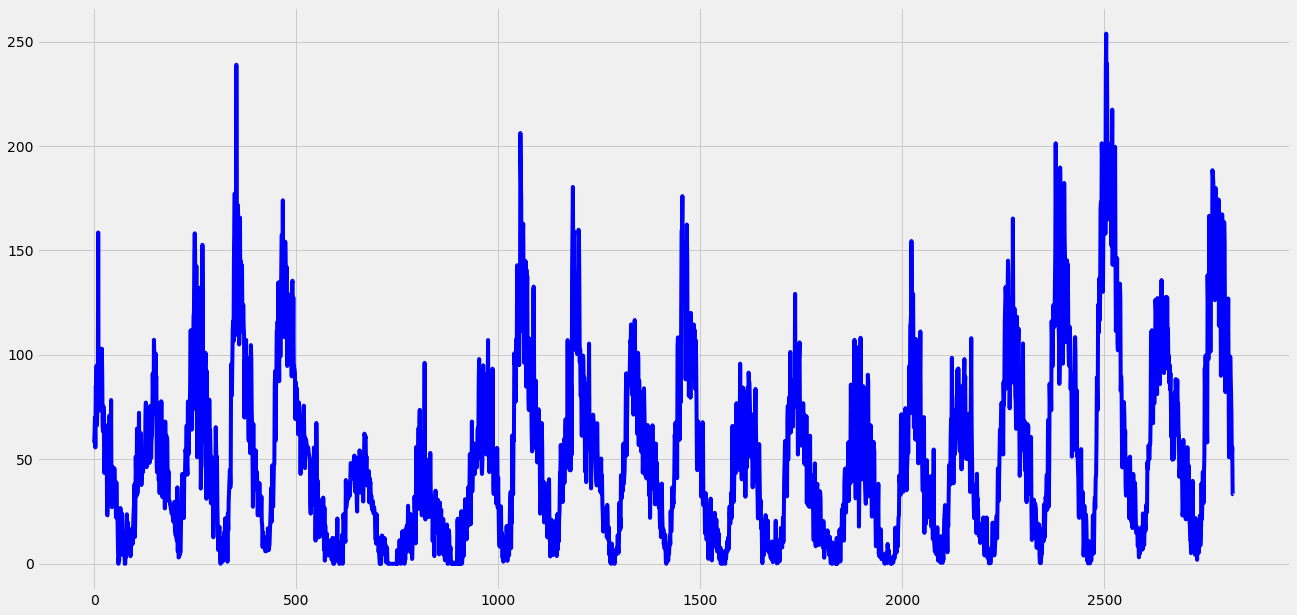

<Figure size 1440x720 with 0 Axes>

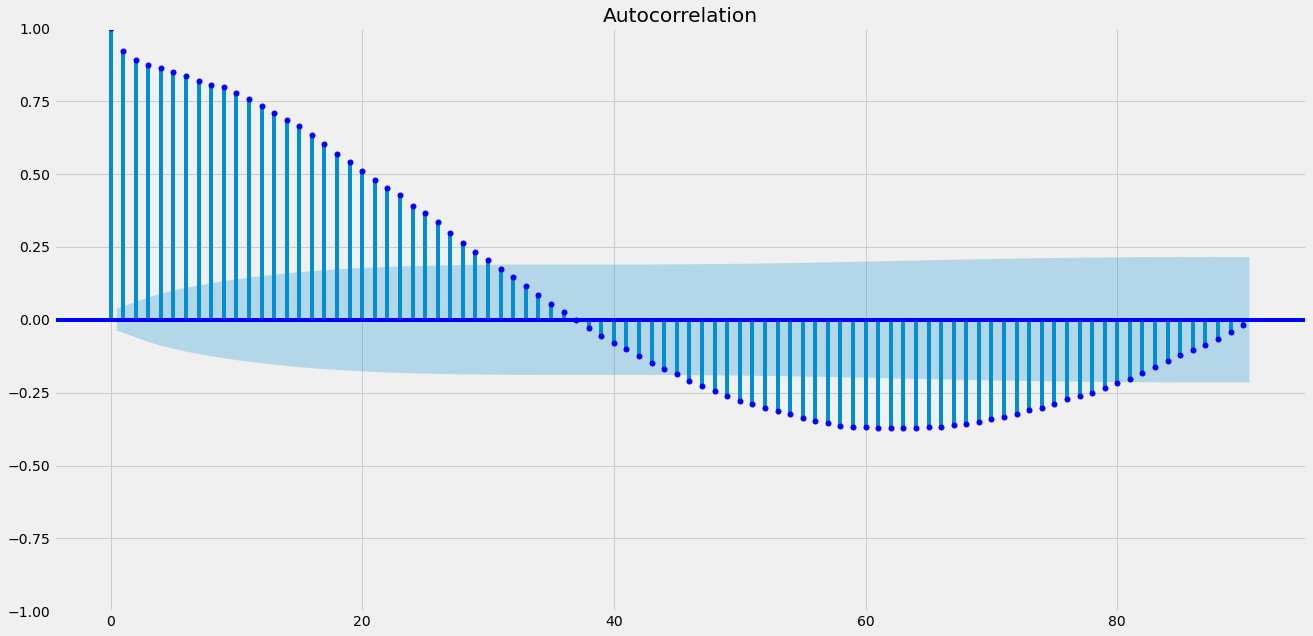

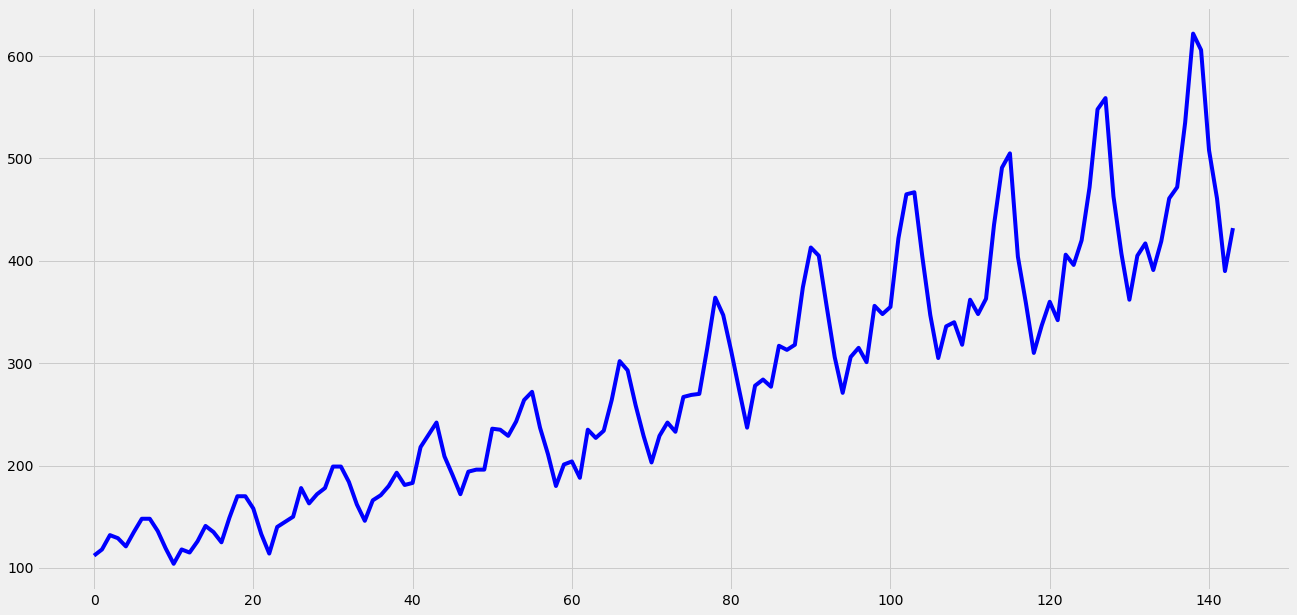

<Figure size 1440x720 with 0 Axes>

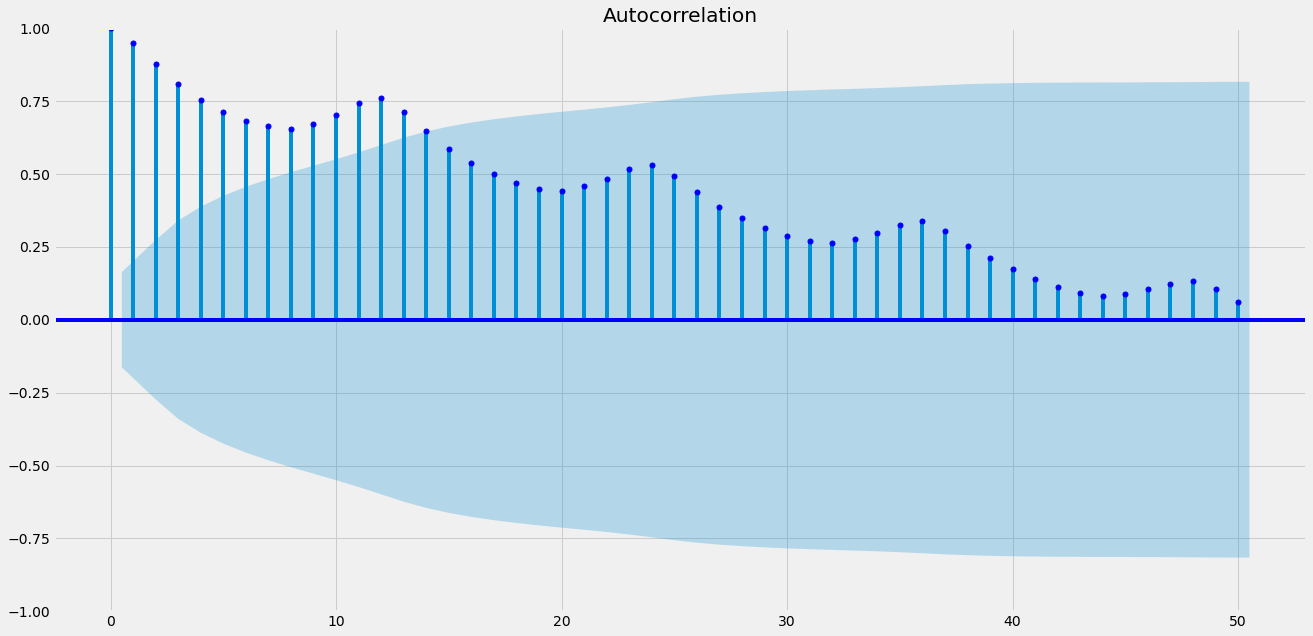

In [18]:
data = pd.read_csv('data/monthly-sunspots.txt').drop(['Month'],axis=1)#.head(100)
data_a = data.to_numpy().T[0]
data_a
plt.figure(figsize=(20,10))
plt.plot(data_a, color="blue")

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_a, lags=90, color="blue")
plt.show()

data = pd.read_csv('data/AirPassengers.csv').drop(['Month'],axis=1)#.head(100)
data_a = data.to_numpy().T[0]
data_a
plt.figure(figsize=(20,10))
plt.plot(data_a, color="blue")

plt.rc("figure", figsize=(20,10))
plt.figure(figsize=(20,10))
plot_acf(data_a, lags=50, color="blue")
plt.show()


when the autocorrolation has a steady decrese, we can state that theres a strong trend,at the beignning of the data 

### Interpreting the correlogram

+ When $x_1, ..., x_n$ are obtained from a purely random process, the probability that a fixed $r_k$ lies outside the bands equals 0.05.

+ A value of $r_k $outside the bands is significant i.e., it gives evidence against pure randomness. However, the overall probability of getting at least one $r_k$ outside the bands increases with the number of coefficients plotted, e.g. if 20 $r_k$ are plotted, one expects to get one significant value under pure randomness.

Rules of thumb for the correlogram are as follows:

+ A single (or two?) $r_k$ just outside the bands may be ignored, but three or more values well outside indicate a departure from pure randomness.
+ A single significant $r_k$ at a lag which has some physical interpretation such as lag one or a lag corresponding to seasonal variation also indicates evidence of non-randomness.
+ If you see that the ACF “dies out” very slowly, then that is an indication of a strong trend.

There are many rules (see, top 13 [here](http://people.duke.edu/~rnau/arimrule.htm)) to judge the correlogram.

## 2.4 Stationarization

Remember that the goal of removing trends and seasonality effects is that we want to find a remainder term $r_t$, as a sequence of correlated random variables with mean zero, i.e. a stationary timeseries.

Techniques we can further employ:
1. taking differences
+ transformations 
+ smoothing approaches (or filtering)
+ more complex parametric models (which we won't cover here)

### 2.4.1 Differencing
If we know that there is a trend but we cannot accurately estimate it, then one way to correct for the trend stationarity would be to try differencing (first-difference (FD) - differencing an observation from its prior observation).
doing on higher degree is takingteh difference f the difference 

We assume a series with an additive trend, but no seasonal variation. We can then write as : $x_t = m_t  + r_t$  . If we perfom differencing and assume a slowly-varying trend (such that $m_t \simeq m_{t+1}$) we obtain:

$$
y_t = x_t - x_{t-1} \simeq r_t - r_{t-1}
$$

and then $y_t$ (aka the difference) is stationary.

The seasonal growth, if present, can be corrected using a logarithmic transformation or seasonal differences.

### 2.4.2 Box-Cox Transformation 

Lets use the Box-Cox transformation to suppress some of the variance. This technique is used to transform non-normal dependent variables into a normal shape.

The Box-Cox transformation is a family of power transformations indexed by a parameter $\lambda$. Whenever you use it the parameter needs to be estimated from the data. The formal definition for a variable, say $x_t$ is as follows:

$$
w_t =
\begin{cases} \log (x_t) & \text{if} \lambda=0 \\
\frac{x_t^{\lambda}-1}{\lambda} & \text{otherwise}
\end{cases}
$$

If $\lambda=1$, then $w_t=x_t−1$, so the transformed data is shifted downwards but there is no change in the shape of the time series. But for all other values of $\lambda$, the time series will change shape. See more on this [link](https://otexts.com/fpp3/transformations.html).

After applying Box-Cox with a particular value of $\lambda$ the process might become stationary (because we reduce the variance). It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary. In that case, we need to rely on further modeling (see below).

In [19]:
from scipy import stats
df['boxcox'], lmbda = stats.boxcox(df.value)

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.boxcox.dropna().values, significance_level) else "no"))

ADF p-value: 0.80034
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Since we have not yet achieved stationarity, we proceed to remove the overall trend using the first-difference (FD), i.e. take differences on the transformed timeseries and also remove the seasonality difference (SD) by assuming a 12 month seasonality effect.

In [20]:
df["fd"] = df.boxcox - df.boxcox.shift(1)
df["stationary"] = df.fd - df.fd.shift(seasons)
df.head(14)

,period,value,boxcox,fd,stationary
0,1988-01-01,119.8,101.280602,NaN,NaN
1,1988-02-01,125.3,105.777261,4.496659,NaN
2,1988-03-01,131.4,110.754816,4.977555,NaN
3,1988-04-01,134.9,113.606393,2.851577,NaN
4,1988-05-01,136.8,115.153090,1.546697,NaN
5,1988-06-01,136.9,115.234470,0.081380,NaN
6,1988-07-01,139.6,117.430796,2.196326,NaN
7,1988-08-01,144.3,121.249808,3.819012,NaN
8,1988-09-01,134.6,113.362095,-7.887713,NaN
9,1988-10-01,137.8,115.966778,2.604684,NaN


In [21]:
print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(df.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(df.stationary.dropna().values, significance_level) else "no"))

ADF p-value: 0.00000
Stationary by ADF: yes 

KPSS p-value: 0.10000
Stationary by KPSS: yes


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


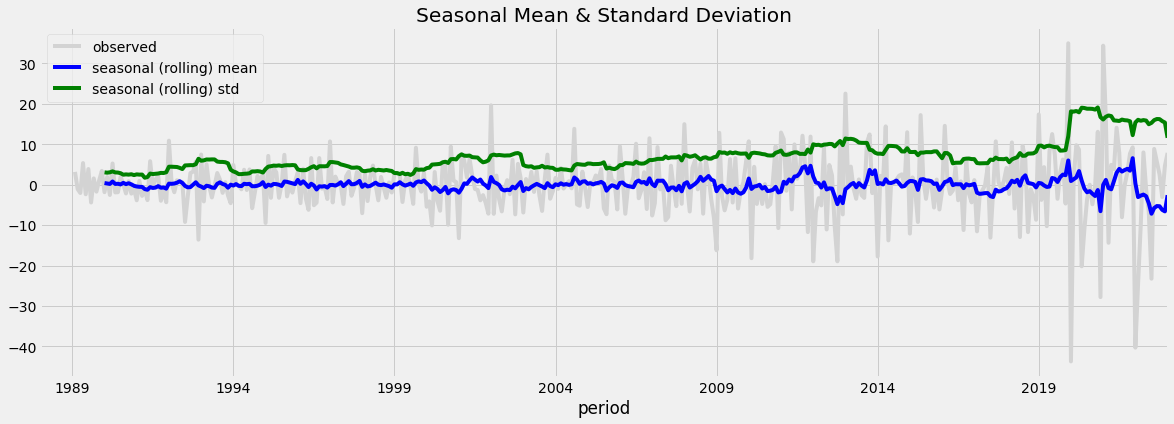

In [22]:
visual_check(df, "stationary", seasons)

### 2.4.3 Smoothing (or Moving averages)

For a time series $x_t$, the *$q$-day moving average at time $t$*, denoted $MA^q_t$, is the average of $x_t$ over the past $q$ days, 

$$
MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}
$$


In [23]:
df["smooth"] = df["stationary"].rolling(window = 20, center = False).mean()
df.tail()

,period,value,boxcox,fd,stationary,smooth
416,2022-09-01,88.6,75.594254,-4.552357,5.718844,-1.941758
417,2022-10-01,105.6,89.629934,14.035679,2.544409,-2.627669
418,2022-11-01,127.9,107.900055,18.270121,-3.037425,-2.061786
419,2022-12-01,162.8,136.233076,28.333022,4.680893,-2.073689
420,2023-01-01,80.3,68.701621,-67.531456,7.866555,-1.872243


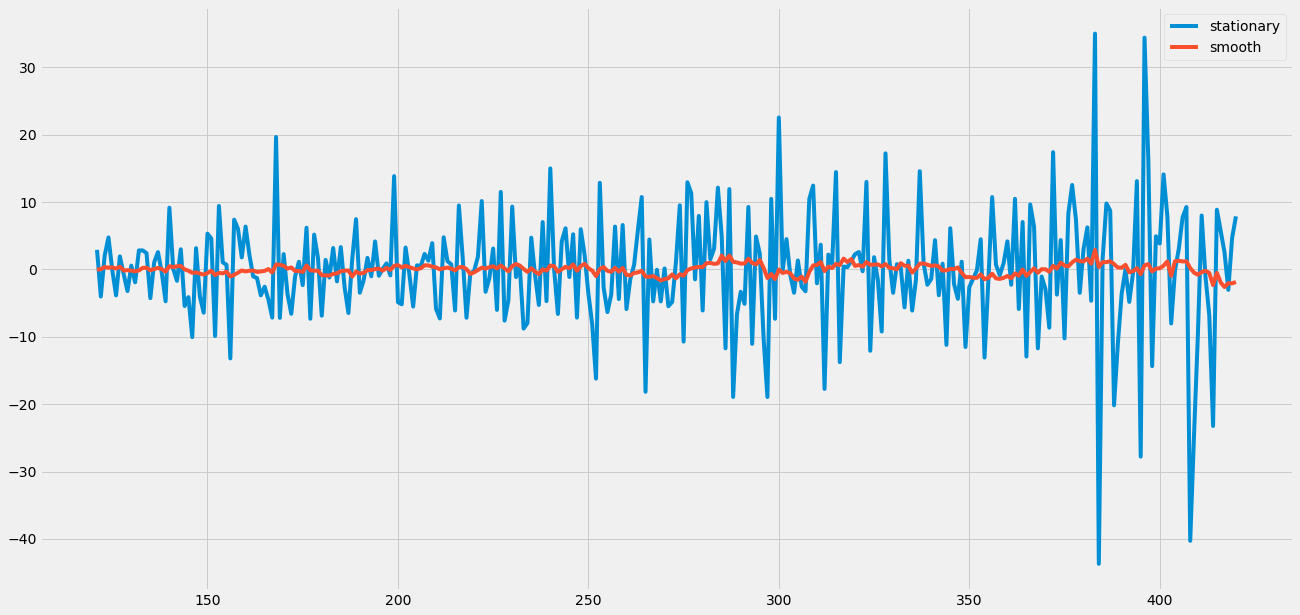

In [24]:
df[["stationary", "smooth"]].tail(300).plot(grid = True); 

**POLL**:
    
If I increase the smoothing window, I get more details about the micro-changes in the timeseries. True of False?

## 3. Further down the predicting/modeling path: Autoregression

We now move to ask whether the next value in the time series can be predicted as some function of its previous values. This is called autoregression.

We want to build a regression model of the current value fitted on one or more previous values (lagged values). But how many?

We can look directly at the correlogram and ask how much information there is in previous values that helps predict the current value. The problem is that if $t[0]$ is correlated with $t[-1]$, and $t[-1]$ is correlated with $t[-2]$, then $t[0]$ will necessarily be correlated with $t[-2]$ also. So we need to “partial out” these effects, to get the unique contribution of each time-lag. We can do that with the Partial Autocorrelation Plot, which shows the correlation between $x(t)$ and $x(t+h)$ after removing the linear relationship of all observations that lie between $x(t)$ and $x(t+h)$.

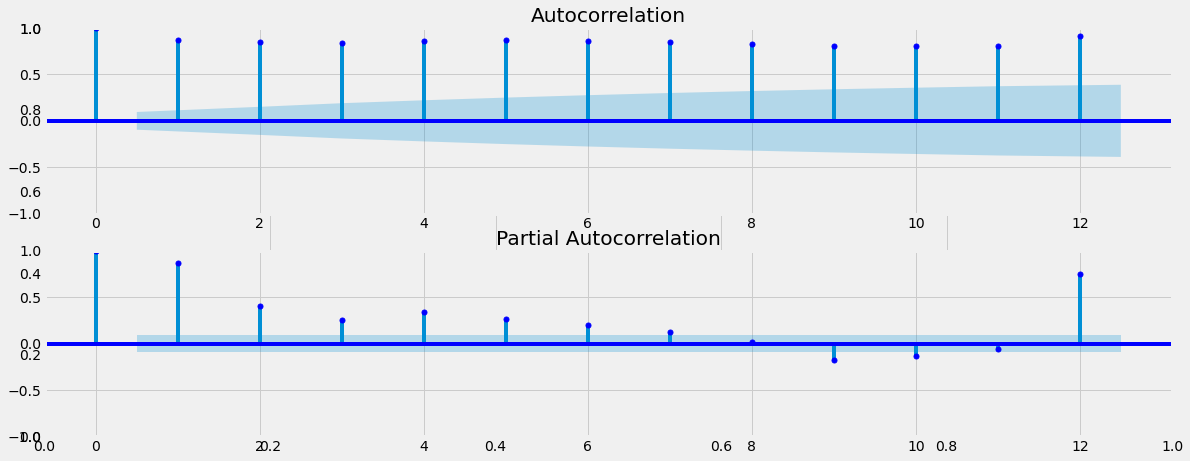

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax1 = plt.subplots(figsize=(18,7))

ax1 = fig.add_subplot(211)
fig = plot_acf(df.value, color = "blue", lags=12, ax=ax1)
#fig = plot_acf(df["stationary"].dropna(inplace=False), color = "blue", lags=12, ax=ax1)

ax1 = fig.add_subplot(212)
fig = plot_pacf(df.value, color = "blue", lags=12, ax=ax1)
#fig = plot_pacf(df["stationary"].dropna(inplace=False), color = "blue", lags=12, ax=ax1)

#plt.savefig('images/stochastic-acf-pacf.png');

We can fit an autoregression model and decide using a criterion (e.g. AIC) how many lagged values should be included in the model.

Practically, I fit a linear regression model where my independent variables are the time-lagged values of my timeseries.

In [26]:
from statsmodels.tsa.ar_model import AutoReg

mod = AutoReg(df.stationary.dropna(inplace=False).iloc[seasons + 1:], 1)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:             stationary   No. Observations:                  395
Model:                     AutoReg(1)   Log Likelihood               -1357.499
Method:               Conditional MLE   S.D. of innovations              7.587
Date:                Thu, 16 Mar 2023   AIC                           2720.999
Time:                        10:40:23   BIC                           2732.928
Sample:                             1   HQIC                          2725.726
                                  395                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0918      0.382     -0.240      0.810      -0.841       0.657
stationary.L1    -0.2430      0.049     -4.966      0.000      -0.339      -0.147
                                    Root

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 4. AutoRegressive Integrated Moving Average (ARIMA) Model 

ARIMA models put together many of the concepts we already discussed (autoregression, differencing, smoothing) and are denoted with the notation $ARIMA (p, d, q)$. These parameters account for seasonality, trend, and noise in datasets:

* p - the number of lag observations to include in the model, or lag order. (AR) order of regression
* d - the number of times that the raw observations are differenced, or the degree of differencing. (I)

* q - the size of the moving average window, also called the order of moving average.(MA)

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model. A value of 0 for a parameter indicates to not use that element of the model.

ARIMA is still a linear model!

$$
y_t = c + \phi_1 y_{d,t-1} + \phi_p y_{d,t-p} + ... + \theta_1 \epsilon_{t-1} + \theta_q \epsilon_{t-q}
$$

Some example models:

ARIMA(0,0,0) is simply predicting the mean of the overall time series, i.e., no structure.

ARIMA(0,1,0) works with differences, not raw values, and predicts the next value without any autoregression or smoothing. 

ARIMA(1,0,0) and ARIMA(24,0,0) are AR models that take into account one previous terms and 24 previous terms respectively.

Notice, that I can also apply the model to learn the seasonal effect.

### 4.1 Determine AR/MA parameters

After a time series has been stationarized, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series.

By looking at the **Autocorrelation (ACF)** and **partial autocorrelation (PACF)** functions plots of the stationarized series, we can identify the numbers of AR and/or MA terms that are needed.

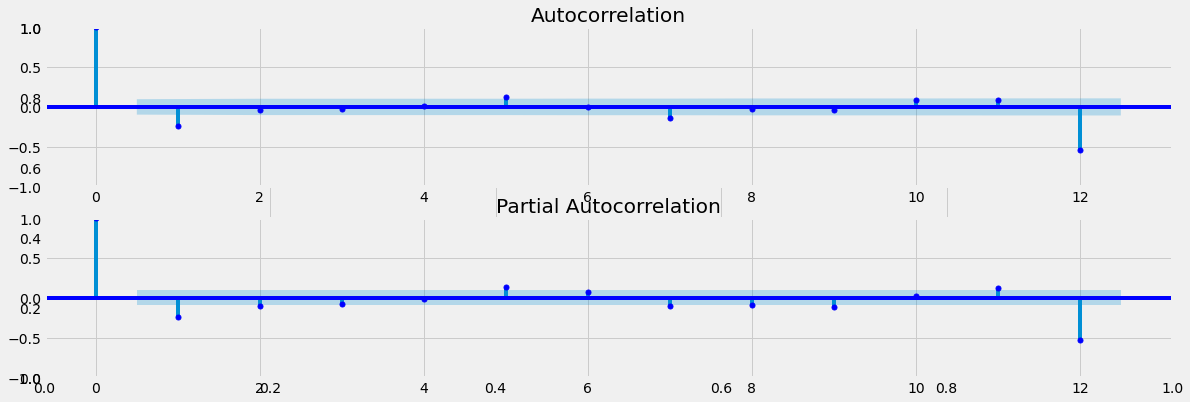

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize=(18,6))

ax = fig.add_subplot(211)
fig = plot_acf(df.stationary.dropna(), color = "blue", lags=12, ax=ax)

ax = fig.add_subplot(212)
fig = plot_pacf(df.stationary.dropna(), color = "blue", lags=12, ax=ax)

#plt.savefig('images/stochastic-acf-pacf.png');

### Rough expectations from ACF/PACF

+ AR(p) model: <br>
ACF “dies off” gradually <br>
PACF “dies off” after p lags <br>

+ MA(q) model: <br>
ACF “dies off” after q lags <br>
PACF “dies off” gradually <br>

+ ARIMA(p,0,q) model: <br>
Both ACF/PACF ”die off” gradually <br>

At the Autocorrelation (ACF) plot there is a significant (negative) correlation with the 1 lag. Similarly, at the partial autocorrelation (PACF) there is a significant (negative) correlation with the 1 lag. We can also take differences of the first order to stationarize the time series, so we will try with $d=1$. We then find a good idea to fit the ARIMA (1,1,1) model.

More info about how to select our model can be found [here](https://people.duke.edu/~rnau/arimrule.htm). Otherwise, we can use cross-validation to determine optimal values for the parameters.

### 4.2 Building the Model

The AR and MA parameters suggest 1 and 1 respectively, thus giving rise to (p, d, q) = (1, 1, 1) respectively.

* `enforce_stationarity=True` - transform the AR parameters to enforce stationarity in the autoregressive component of the model

* `enforce_invertibility=True` - transform the MA parameters to enforce invertibility in the moving average component of the model.

Read more about the documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html). ARIMA model can also be extended to handle seasonal effects by applying the same process to the seasonal component, i.e. model seasonal component as a timeseries as well. For that we need to identify (estimate) 4 additional parameters (P: Seasonal autoregressive order, D: Seasonal difference order, Q: Seasonal moving average order, m: The number of time steps for a single seasonal period). The model then becomes: SARIMA$(p,d,q) \times (P,D,Q)_m$


Below we use the more general SARIMAX model (see documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) and some more examples [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)). 

In [28]:
train_range = df[df.period < '2018-01-01'].index
test_range = df[(df.period >= '2018-01-01')].index

#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax

In [29]:
model = sarimax.SARIMAX(
    np.log(df.loc[train_range].set_index("period").value),
    trend='n', #identifies non-constant trend (other options: c for constant etc.)
    order=(1,1,1),
    seasonal_order=(1,1,1,12), #seasonal component
    enforce_stationarity=True,
    enforce_invertibility=True)

results = model.fit()
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  360
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 559.657
Date:                            Thu, 16 Mar 2023   AIC                          -1109.314
Time:                                    10:40:24   BIC                          -1090.067
Sample:                                01-01-1988   HQIC                         -1101.651
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1321      0.103      1.288      0.198      -0.069       0.333
ma.L1         -0.5027      0.086   

### 4.3 Making predictions and evaluating the model

In [30]:
steps = test_range.shape[0]

forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()

yhat_test = np.exp(forecast.predicted_mean).values
y_test = df.loc[test_range].value.values

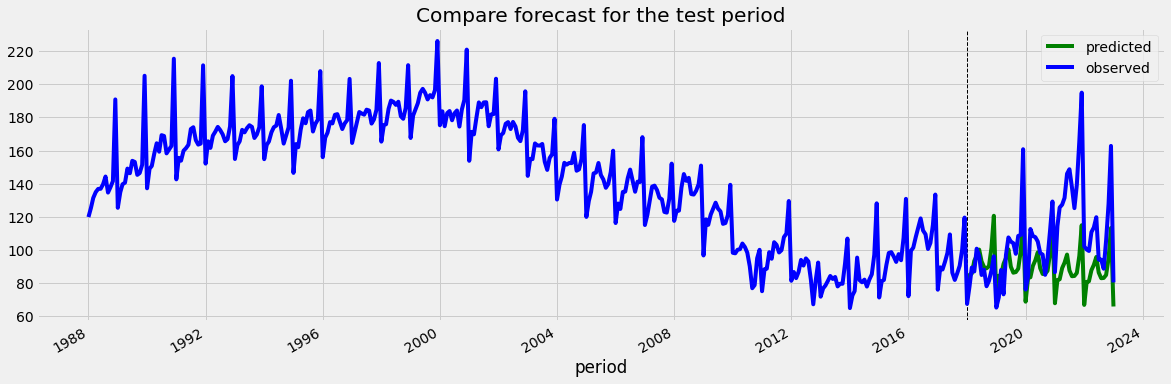

In [31]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="green", label="predicted")

plt.axvline(pd.to_datetime(str(df.loc[test_range].period.values[0])), c='black', ls='--', lw=1)
df.plot(x="period", y="value", color="blue", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

#plt.savefig('images/stochastic-forecast-testrange.png')
plt.show();

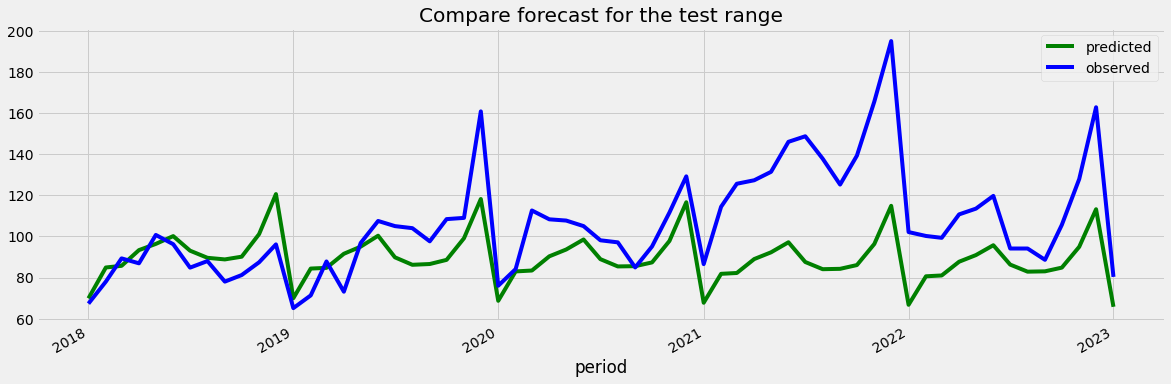

In [32]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test, color="green", label="predicted")

df.loc[test_range].plot(x="period", y="value", ax=ax, color = "blue", label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

#plt.savefig('images/stochastic-forecast-testrange-zoom.png')
plt.show();

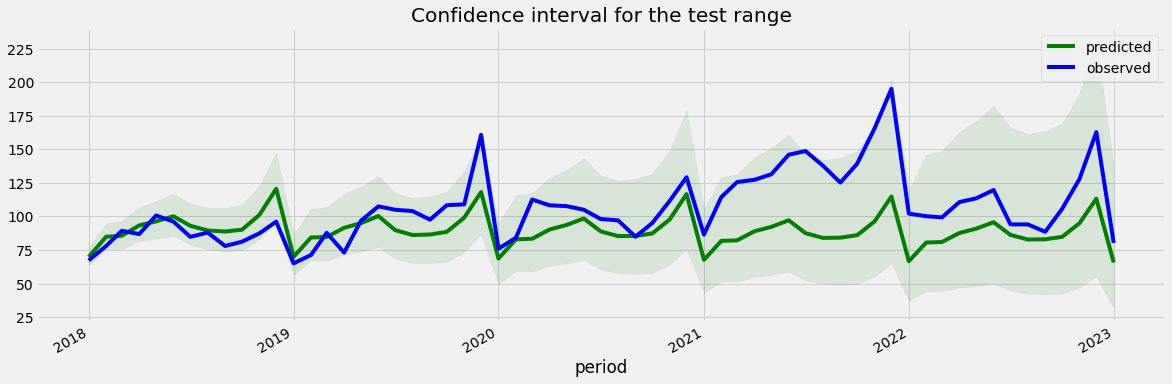

In [33]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(df.loc[test_range].period.values), yhat_test,
        color="green", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    np.exp(forecast_ci['lower value']),
    np.exp(forecast_ci['upper value']),
    color='g',
    alpha=0.1)

df.loc[test_range].plot(x="period", y="value", ax=ax, color="blue",label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

#plt.savefig('images/stochastic-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

We can use the standard measures to evaluate our model (e.g. distance measures) or even employ the $R^2$ coefficient.

In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [35]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)

print("MAE (test): {:0.1f}".format(mae))
print("MSE (test): {:0.1f}".format(mse))

MAE (test): 20.6
MSE (test): 752.9


### Evaluate the prediction for near-future (12 months) only

In [36]:
mae = mean_absolute_error(y_test[:12], yhat_test[:12])
mse = mean_squared_error(y_test[:12], yhat_test[:12])

print("MAE (test): {:0.1f}".format(mae))
print("MSE (test): {:0.1f}".format(mse))

MAE (test): 8.0
MSE (test): 99.7


ts messes up the models for seasonal, 
we can visualize it and identify the trends or seasonal effects we can then remove it to a stationary part (check visualiy and telelogram ) used for modelling, 